In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

c:\Users\Franco\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
df1 = pd.read_csv('D:/Curso Henry/Proyecto final/CSV_Tablas finales/Ventas.csv')


In [5]:
df1.head()

,InventoryId,Store,Brand,SalesQuantity,SalesDollars,SalesPrice,SalesDate,ExciseTax
0,1_HARDERSFIELD_1001,1,1001,1,"5,99","5,99",2016-08-05,0.05
1,1_HARDERSFIELD_1001,1,1001,1,"5,99","5,99",2016-08-12,0.05
2,1_HARDERSFIELD_1001,1,1001,1,"5,99","5,99",2016-08-20,0.05
3,1_HARDERSFIELD_1001,1,1001,1,"5,99","5,99",2016-08-29,0.05
4,1_HARDERSFIELD_1001,1,1001,1,"5,99","5,99",2016-09-08,0.05


In [5]:
print(len(df1))
print(df1['SalesDate'].dtype)

6412657
object


In [6]:
columnas_coma = ['SalesDollars', 'SalesPrice', 'ExciseTax', 'SalesQuantity']

for col in columnas_coma:
    df1[col] = df1[col].astype(str).str.replace(',', '.', regex=False)

In [7]:
# Convierte a float
df1['SalesDollars'] = pd.to_numeric(df1['SalesDollars'], errors='coerce')
df1['SalesPrice'] = pd.to_numeric(df1['SalesPrice'], errors='coerce')
df1['ExciseTax'] = pd.to_numeric(df1['ExciseTax'], errors='coerce')
df1['SalesQuantity'] = pd.to_numeric(df1['SalesQuantity'], errors='coerce')

In [8]:
# Forzamos conversión eficiente de la columna 'Sales date' a datetime
df1['SalesDate'] = pd.to_datetime(df1['SalesDate'], errors='coerce', format='%Y-%m-%d', infer_datetime_format=True)

# Verificamos si hubo errores
print("Fechas nulas:", df1['SalesDate'].isnull().sum())


C:\Users\Franco\AppData\Local\Temp\ipykernel_20020\1998059614.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df1['SalesDate'] = pd.to_datetime(df1['SalesDate'], errors='coerce', format='%Y-%m-%d', infer_datetime_format=True)


Fechas nulas: 0


In [9]:
# Usamos resample para performance
ventas_mensuales = (
    df1.set_index('SalesDate')
       .resample('M')['SalesDollars']
       .sum()
       .reset_index()
)

# Renombramos columnas para Prophet
df_prophet = ventas_mensuales.rename(columns={'SalesDate': 'ds', 'SalesDollars': 'y'})

C:\Users\Franco\AppData\Local\Temp\ipykernel_20020\1623102697.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['SalesDollars']


In [10]:
model = Prophet()
model.fit(df_prophet)

13:02:36 - cmdstanpy - INFO - Chain [1] start processing
13:02:37 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Generamos 12 meses futuros
future = model.make_future_dataframe(periods=12, freq='M')

# Hacemos la predicción
forecast = model.predict(future)

c:\Users\Franco\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


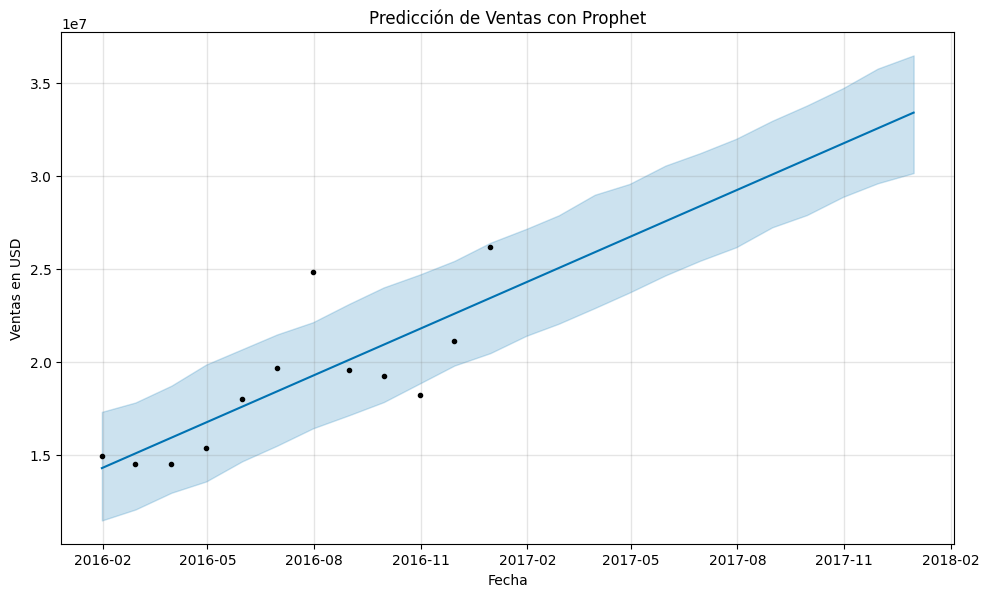

In [12]:
model.plot(forecast)
plt.title('Predicción de Ventas con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Ventas en USD')
plt.show()

In [13]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
12,2017-01-31,2.428697e+07,2.140498e+07,2.715772e+07
13,2017-02-28,2.505195e+07,2.205562e+07,2.788804e+07
14,2017-03-31,2.589890e+07,2.289503e+07,2.899238e+07
15,2017-04-30,2.671853e+07,2.373189e+07,2.957480e+07
16,2017-05-31,2.756548e+07,2.465557e+07,3.056238e+07
17,2017-06-30,2.838511e+07,2.544476e+07,3.123284e+07
18,2017-07-31,2.923206e+07,2.616894e+07,3.200376e+07
19,2017-08-31,3.007901e+07,2.723915e+07,3.297093e+07
20,2017-09-30,3.089864e+07,2.790196e+07,3.379468e+07
21,2017-10-31,3.174559e+07,2.887573e+07,3.472336e+07


In [14]:
model = Prophet(
    yearly_seasonality=False,  # no es útil con solo 1 año
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

In [15]:
model.add_seasonality(name='mensual', period=30.5, fourier_order=5)

In [16]:
model = Prophet(
    weekly_seasonality=True,
    seasonality_mode='multiplicative'
)

In [17]:
model.add_seasonality(name='mensual', period=30.5, fourier_order=3)

In [19]:
df1['SalesDate'] = pd.to_datetime(df1['SalesDate'])
ventas_semanales = (
    df1.set_index('SalesDate')
       .resample('W')['SalesDollars']
       .sum()
       .reset_index()
       .rename(columns={'SalesDate': 'ds', 'SalesDollars': 'y'})
)

In [23]:
df_prophet = df1.groupby(df1['SalesDate'].dt.to_period('M'))['SalesDollars'].sum().reset_index()
df_prophet['SalesDate'] = df_prophet['SalesDate'].dt.to_timestamp()
df_prophet = df_prophet.rename(columns={'SalesDate': 'ds', 'SalesDollars': 'y'})

In [24]:
from prophet import Prophet

model = Prophet(
    weekly_seasonality=True,
    seasonality_mode='multiplicative'
)

# ¡Este paso es crítico!
model.fit(df_prophet)

13:34:01 - cmdstanpy - INFO - Chain [1] start processing
13:34:01 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

c:\Users\Franco\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


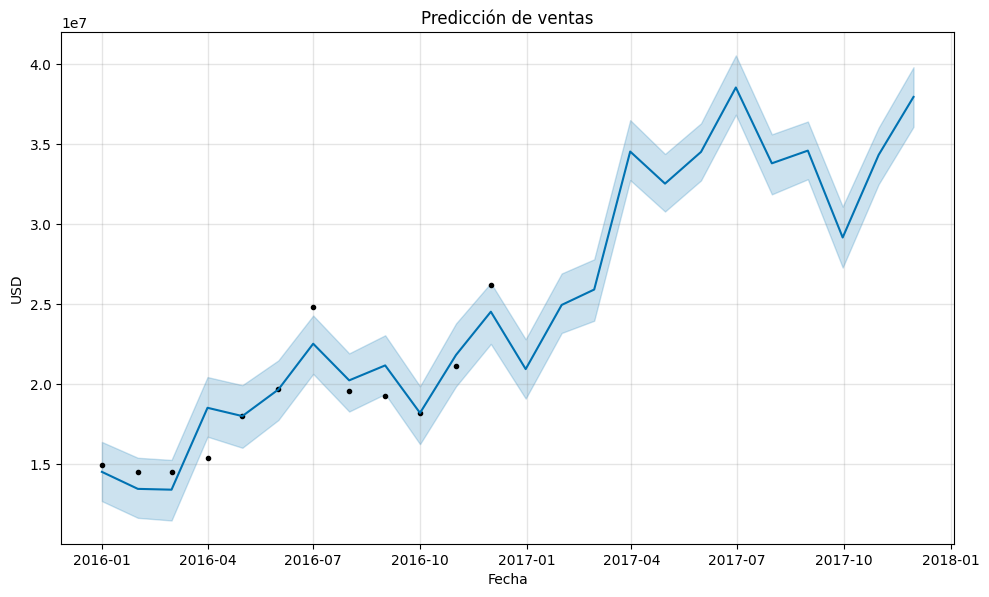

In [26]:
import matplotlib.pyplot as plt

fig = model.plot(forecast)
plt.title('Predicción de ventas')
plt.xlabel('Fecha')
plt.ylabel('USD')
plt.show()